In [209]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\prk\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [210]:
dataset = pd.read_csv('financial_sentiment.csv')
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5842 entries, 0 to 5841
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Sentence   5842 non-null   object
 1   Sentiment  5842 non-null   object
dtypes: object(2)
memory usage: 91.4+ KB


In [211]:
dataset.describe()

,Sentence,Sentiment
count,5842,5842
unique,5322,3
top,Managing Director 's comments : `` Net sales f...,neutral
freq,2,3130


In [212]:
dataset.head()

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral


In [213]:
dataset

,Sentence,Sentiment
0,The GeoSolutions technology will leverage Bene...,positive
1,"$ESI on lows, down $1.50 to $2.50 BK a real po...",negative
2,"For the last quarter of 2010 , Componenta 's n...",positive
3,According to the Finnish-Russian Chamber of Co...,neutral
4,The Swedish buyout firm has sold its remaining...,neutral
...,...,...
5837,RISING costs have forced packaging producer Hu...,negative
5838,Nordic Walking was first used as a summer trai...,neutral
5839,"According shipping company Viking Line , the E...",neutral
5840,"In the building and home improvement trade , s...",neutral


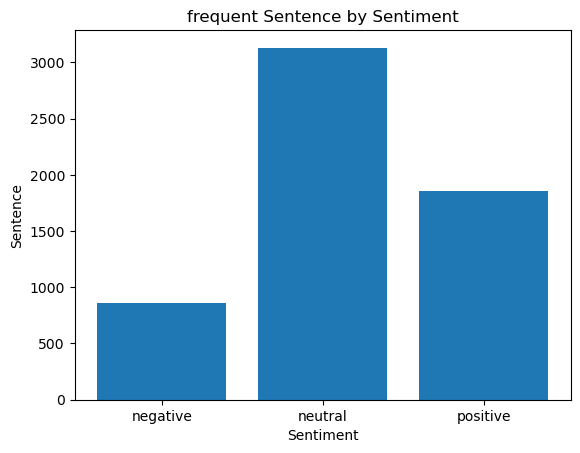

In [214]:
# count sentences

countse = dataset.groupby('Sentiment')['Sentence'].count()
plt.bar(countse.index, countse.values)
plt.xlabel('Sentiment')
plt.ylabel('Sentence')
plt.title('frequent Sentence by Sentiment')
plt.show()

In [215]:
from sklearn.utils import resample
grouped = dataset.groupby('Sentiment')
resample_list = []
for sentiment, group in grouped:
    resample_group = resample(group, replace=True, n_samples=3000)
    resample_list.append(resample_group)
dataset = pd.concat(resample_list)

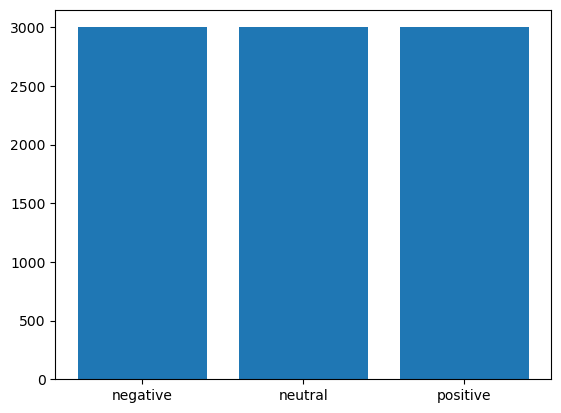

In [216]:
countse = dataset.groupby('Sentiment')['Sentence'].count()
plt.bar(countse.index, countse.values)
plt.show()

In [217]:
# # remove special character, turn lower case, remove stop words
def remove_special(text):
    new_string = ''
   
    for character in text:
        if character.isalnum() or character.isspace():
            new_string += character
    return new_string

def lower(text):
    return text.lower()

def remove_stop(text):
    stopword = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word not in stopword]
    return ' '.join(filtered_words)

In [218]:
dataset['Sentence'] = dataset['Sentence'].apply(remove_special)
dataset['Sentence'] = dataset['Sentence'].apply(lower)
dataset['Sentence'] = dataset['Sentence'].apply(remove_stop)

In [219]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
dataset['Sentiment'] = label_encoder.fit_transform(dataset['Sentiment'])
dataset.head()

,Sentence,Sentiment
1247,national conciliator juhani salonius met parti...,0
496,antti orkola president kemira growhow industri...,0
1571,operating profit totalled eur 90 mn eur 97 mn ...,0
257,altogether finnair canceled 500 flights strike,0
2178,baltic states company reports net sales eur 11...,0


In [220]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [221]:
token = Tokenizer()
token.fit_on_texts(dataset['Sentence'])
word_index = token.word_index
sequence = token.texts_to_sequences(dataset['Sentence'])
seq_len = [len(seq) for seq in sequence]


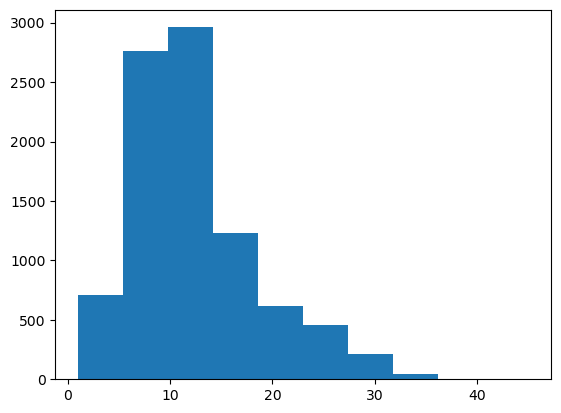

In [222]:
plt.hist(seq_len)
plt.show()

In [223]:
from tensorflow.keras.preprocessing.sequence import pad_sequences


In [224]:
padded = pad_sequences(sequence, maxlen=50)

In [244]:
dataset['Sentiment']

1247    0
496     0
1571    0
257     0
2178    0
       ..
4253    2
685     2
118     2
710     2
1087    2
Name: Sentiment, Length: 9000, dtype: int32

In [225]:
from sklearn.model_selection import train_test_split

In [237]:
xtrain, xtemp, ytrain, ytemp = train_test_split(padded, dataset['Sentiment'], test_size=0.2, random_state=42)
xtest, xval, ytest, yval = train_test_split(xtemp, ytemp, test_size=0.5, random_state=42)

In [245]:
ytrain.shape

(7200,)

In [246]:
yval.shape

(900,)

In [248]:
xval.shape

(900, 50)

In [238]:
from tensorflow.keras.layers import Embedding, Dense, GlobalAveragePooling1D
from tensorflow.keras.models import Sequential


In [239]:
model = Sequential([
    Embedding(input_dim=len(word_index)+1, output_dim=512),
    GlobalAveragePooling1D(),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(3, activation='softmax')
])

In [240]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [241]:
from tensorflow.keras.callbacks import EarlyStopping

In [242]:
early = EarlyStopping(monitor='val_loss', patience=10)

In [243]:
history = model.fit(xtrain, ytrain, epochs=10, batch_size=128, validation_data=(xval, yval), callbacks=[early])

Epoch 1/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - accuracy: 0.3509 - loss: 1.0971 - val_accuracy: 0.3733 - val_loss: 1.0749
Epoch 2/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.5186 - loss: 1.0004 - val_accuracy: 0.6711 - val_loss: 0.7900
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7591 - loss: 0.6565 - val_accuracy: 0.8256 - val_loss: 0.5012
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8722 - loss: 0.3581 - val_accuracy: 0.8511 - val_loss: 0.4128
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.8846 - loss: 0.3017 - val_accuracy: 0.8089 - val_loss: 0.4827
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9089 - loss: 0.2416 - val_accuracy: 0.8778 - val_loss: 0.3772
Epoch 7/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9325 - loss: 0.1756 - val_accuracy: 0.8500 - val_loss: 0.4118
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9384 - loss: 0.1544 - val_accuracy: 0.8944 - v

Text(0.5, 1.0, 'model loss')

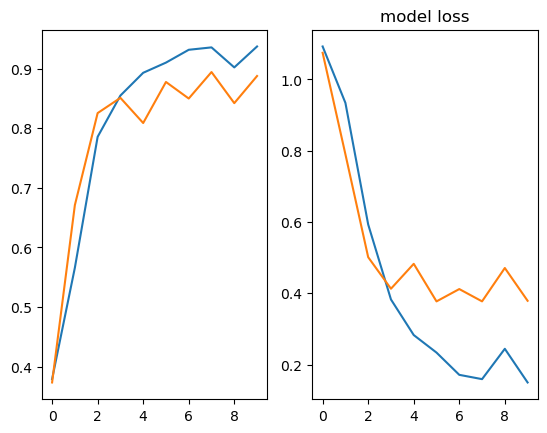

In [249]:
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train acc')
plt.plot(history.history['val_accuracy'], label='val acc')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('model loss')

In [251]:
loss, accuracy = model.evaluate(xtest, ytest)
print(f'loss: {loss}\naccuracy: {accuracy}')

29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step - accuracy: 0.8812 - loss: 0.3366
loss: 0.3499159812927246
accuracy: 0.8811110854148865


In [253]:
ypred = np.argmax(model.predict(xtest[:10]), axis=1)
for i in range(10):
    print(f'actual: {ytest.iloc[i]} | predicted: {ypred[i]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
actual: 0 | predicted: 1
actual: 0 | predicted: 0
actual: 0 | predicted: 0
actual: 1 | predicted: 1
actual: 1 | predicted: 1
actual: 1 | predicted: 1
actual: 2 | predicted: 2
actual: 2 | predicted: 2
actual: 2 | predicted: 2
actual: 1 | predicted: 1
